issues to resolve:

1.   get the path to run the data only once, not in each block.
2.   fix the inline images paths to sth permenant(lab github)
3.   binocular showing patches issue
4.  fix plot colormaps


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive")

***
**<h1 style="text-align:center;">Multimodal Neural Efficient Coding Integration</h1>**


This notebook demonstrates the efficient coding principle across various sensory modalities. Modalities include black and white images, color images, and audio. The code for these modalities have been adapted from COMP386 coursework and tutorials.

# Table of Contents

1. Background and Motivation
2. Methodology
3. Implementation
    * [Black and White Vision](#bw)
    * [Color Vision](#color)
    * [Audio Signals](#audio)
    * [Binocular Vision](#binocular)
    * [Video](#video)
4. Conclusion

# Background and Motivation
***

The lowest level of stimuli processing in the brain across several sensory modalities can be modeled using the same algorithm regardless of the kind of input. This demonstrates the **efficient coding hypothesis**.

Efficient encoding states that the brain aims to minimize energy usage via independent coding, which attempts to minimize redundancy among firing neurons while producing this code. Thus, when one neuron fires the the receptive field it is representing varies from those represented by other neurons. This is well represented by <b>Independent Components Analysis</b>.

# Methodology
***

This presentation aims to demonstrate the efficient coding hypothesis by modeling sensory processing of various modalities: (1) black and white vision, (2) color vision, and (3) hearing. Since the efficient coding hypothesis utilizes the same algorithm regardless of the input, the steps followed for efficient encoding remains identical irrespective of the modality being modeled. The steps to perform efficient coding are as follows:
1. Extract random samples from sensory data (in this case, **patches**).
2. Run PCA and ICA algorithms on these collected patches.
3. Display the neurally-encoded patches (referred to as **filters**).

# Implementation
***

We apply encoding algorithms on three different modalities of sensory data. The application of efficient coding algorithms for each modality is described in subsequent sections.

## Import modules and libraries

This block of code imports all the packages that are needed to perform efficient coding. All three modalities require the input to be pre-processed before the algorithm is applied to generate filters. Additionally, the generated filters need to be viewed to understand the effects of ICA and PCA encoding. These functionalities are implemented as helper methods in a standalone script named ***ica_helper_methods.py***. In order to use these methods during the encoding process, the script is imported as a module in this notebook via the import statement (shown below). To know how these helper methods have been defined or implemented, refer *ica_helper_methods.py* located under the project root directory.

In [3]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pylab as py
#%matplotlib inline
from IPython.display import Image, Audio
import math
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import pylab
from scipy import ndimage
import matplotlib
import wave
import sys
import random as random


# this function collects patches from black and white images
def collectPatchesBW(numPatches, patchWidth, filePath):
    maxTries = numPatches * 50
    firstPatch = 0 # the first patch number accepted from an image
    firstTry = 0 # the first attempt to take a patch from the image
    patchCount = 0 # number of collected patches
    tryCount = 0 # number of attempted collected patches
    numPixels = patchWidth * patchWidth
    patchSample = np.zeros([patchWidth,patchWidth],'double')
    patch = np.zeros([numPixels,1],'double')
    imgPatches = np.zeros([numPixels,numPatches],'double')
    # chooses the image that we're sampling from
    imgCount = 1
    image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
    imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread(filePath + str(imgCount) + '.jpg').shape
    image = image.convert('L')
    image = np.asarray(image, 'double').transpose()
    # normalizing the image
    image -= image.mean()
    image /= image.std()
    while patchCount < numPatches and tryCount < numPatches:
        tryCount += 1
        if (tryCount - firstTry) > maxTries/2 or (patchCount - firstPatch) > numPatches/2:
        # change the image sampled from to the next in the folder
            imgCount += 1
            image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
            imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread(filePath + str(imgCount) + '.jpg').shape
            image = image.convert('L')
            image = np.asarray(image, 'double').transpose()
            # normalizing the image
            image -= image.mean()
            image /= image.std()
            firstPatch = patchCount
            firstTry = tryCount
        #starts patch collection in a random space
        px = np.random.randint(0,imageWidth - patchWidth)
        py = np.random.randint(0,imageHeight - patchWidth)
        patchSample = image[px:px+patchWidth,py:py+patchWidth].copy()
        patchStd = patchSample.std()
        if patchStd > 0.0: # > 0 to remove blank/uninteresting patches for speed
            # create the patch vector
            patch = np.reshape(patchSample, numPixels)
            patch = patch - np.mean(patch)
            imgPatches[:,patchCount] = patch.copy()
            patchCount += 1
    return imgPatches

#this function displays black and white image patches
def showPatchesBW(prePatches, showPatchNum = 16, display=True):
    patches = prePatches
    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim)))
    # extract show_patch_num patches
    displayPatch = np.zeros([dataDim, showPatchNum], float)
    # NORMALIZE PATCH LUMINANCE VALUES
    for i in range(0,showPatchNum):
        #patch_i = i * totalPatches // showPatchNum
        patch_i = i
        patch = patches[:,patch_i].copy()
        pmax  = patch.max()
        pmin = patch.min()
        # fix patch range from min to max to 0 to 1
        if pmax > pmin:
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:,i] = patch.copy()
    bw = 5    # border width
    pw = patchWidth
    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0,showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY
        reshaped = displayPatch[:,i].reshape((pw,pw))
        fullPatch = np.zeros([pw, pw], float)
        fullPatch[0:pw,:] = reshaped[:,:].copy()
        patchImg[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatch

    if display:
        py.bone()
        py.imshow(patchImg.T, interpolation='nearest')
        py.axis('off')
    return


# this function collects patches from color images
def collectPatchesColor(numPatches, patchWidth, filePath):
    maxTries = numPatches * 50
    imageWidth = 200
    firstPatch = 0  # the first patch number accepted from an image
    firstTry = 0  # the first attempt to take a patch from the image
    patchCount = 0  # number of collected patches
    tryCount = 0  # number of attempted collected patches
    numPixels = 3 * patchWidth * patchWidth
    patchSample = np.zeros([3, patchWidth, patchWidth], float)
    patch = np.zeros([numPixels], float)
    imgPatches = np.zeros([numPixels, numPatches], float)
  # this chooses the image we're sampling from, starting from the first image
    imgCount = 1
    image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
    image = np.asarray(image, 'double').transpose()
    image = image[0:3, :, :]
  # normalizing the image
    image -= image.mean()
    image /= image.std()
  # collect the patches from images in file
    while patchCount < numPatches and tryCount < maxTries:
        tryCount += 1  # number of total patches attempted
        if tryCount - firstTry > maxTries / 2 or patchCount             - firstPatch > numPatches / 2:
            imgCount += 1  # this switches to the next image we're sampling from!
            image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
            image = np.asarray(image, 'double').transpose()
            image = image[0:3, :, :]
            image -= image.mean()
            image /= image.std()
            firstPatch = patchCount
            firstTry = tryCount
        px = np.random.randint(0, imageWidth - patchWidth)
        py = np.random.randint(0, imageWidth - patchWidth)
        patchSample = image[:, px:px + patchWidth, py:py
                            + patchWidth].copy()
        patch_std = patchSample.std()
        if patch_std > 0.0:  # > 0 to remove blank/uninteresting patches for speed
      # create the patch vector
            patch = np.reshape(patchSample, numPixels)
            patch = patch - np.mean(patch)
            imgPatches[:, patchCount] = patch.copy()
            patchCount += 1
    return imgPatches

#this function displays color image patches
def showPatchesColor(prePatches, showPatchNum=16, display=True):
    patches = prePatches
    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim/3)))
  # extract showPatchNum patches
    displayPatch = np.zeros([dataDim, showPatchNum], float)
    # NORMALIZE PATCH LUMINANCE VALUES
    for i in range(0, showPatchNum):
        #patch_i = i * totalPatches // showPatchNum
        patch_i = i
        patch = patches[:, patch_i].copy()
        pmax = patch.max()
        pmin = patch.min()
    # fix patch range from min to max to 0 to 1
        if pmax > pmin:
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:, i] = patch.copy()
    bw = 5  # border width
    pw = patchWidth
    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([3, (pw + bw) * patchesX
            - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0, showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY
    # reshape patch sizing
        reshaped = displayPatch[:, i].reshape((3, pw, pw))
        fullPatch = np.zeros([3, pw, pw], float)
        fullPatch[0:3, 0:pw, 0:pw] = reshaped[:, :, :].copy()
        patchImg[:, x_i * (pw + bw):x_i * (pw + bw) + pw, y_i * (pw
                 + bw):y_i * (pw + bw) + pw] = fullPatch
    if display:
    # displays the patches
        py.imshow(patchImg[:, :, :].T, interpolation='nearest')
        py.axis('off')
    return


#this function collects patches from audio clips
def collectPatchesAudio(file):
    # spf = wave.open('audio/' + file + '.wav','r')
    spf = wave.open(file + '.wav','r')

    # extract raw audio from .wav file
    signal = spf.readframes(-1)
    # signal = np.frombuffer(signal, 'Int16')
    signal = np.frombuffer(signal, np.int16)

    fs = spf.getframerate()
    print(fs)
    numSamples = len(signal)
    width = 100
    ds = 3
    numPatches = 100000
    audioPatches = np.zeros((numPatches,width))
    for i in range(numPatches):
        x_start = np.random.randint(0,numSamples-ds*width-2)
        audioPatches[i,:] = signal[x_start:x_start+ds*width-1:ds]
    return(audioPatches)

#this function displays audio patches
def showPatchesAudio(patches):
    width = 100
    cnt = 0
    for cnt in range(20):
        plt.subplot(5, 5, cnt+1)
        frame = pylab.gca()
        frame.axes.get_xaxis().set_ticklabels([])
        frame.axes.get_yaxis().set_ticklabels([])
        plt.plot(range(width),patches[cnt,:])
    plt.show()


def collectPatchesBinocular(numPatches, patchWidth, filePath):
    maxTries = numPatches * 50
    firstPatch = 0 # the first patch number accepted from an image
    firstTry = 0 # the first attempt to take a patch from the image
    patchCount = 0 # number of collected patches
    tryCount = 0 # number of attempted collected patches
    numPixels = patchWidth * patchWidth
    patchSample = np.zeros([patchWidth,patchWidth],'double')
    patchSampleL = np.zeros([numPixels,numPatches],'double')
    patchSampleR = np.zeros([numPixels,numPatches],'double')
    patch = np.zeros([numPixels,1],'double')
    #imgPatches = np.zeros([numPixels,numPatches],'double')
    imgPatchesL = np.zeros([numPixels,numPatches],'double')
    imgPatchesR = np.zeros([numPixels,numPatches],'double')
    # chooses the image that we're sampling from
    imgCount = 1
    image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
    Height = image.height
    Width = image.width
    imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread(filePath + str(imgCount) + '.jpg').shape
    image = image.convert('L')

    left1 = 0
    top1 = 0
    right1 = 1060 // 2
    bottom1 = 496

    left2 = 1060 // 2
    top2 = 0
    right2 = 1060
    bottom2 = 496

    image_left = image.crop((left1, top1, right1, bottom1))
    image_right = image.crop((left2, top2, right2, bottom2))
    left_width = image_left.width
    right_width = image_right.width

    ## no error yet
    imageL = np.asarray(image_left, 'double').transpose()
    # normalizing the image
    imageL -= imageL.mean()
    imageL /= imageL.std()

    imageR = np.asarray(image_right, 'double').transpose()
    # normalizing the image
    imageR -= imageR.mean()
    imageR /= imageR.std()

    #########################################################

    image = np.asarray(image, 'double').transpose()
    # normalizing the image
    image -= image.mean()
    image /= image.std()

    px = np.random.randint(0, left_width - patchWidth)
    py = np.random.randint(0, Height - patchWidth)

    '''
    lx = np.random.randint(0,left_width // 2)
    ly = np.random.randint(0, imageHeight // 2)
    rx = np.random.randint(0,right_width // 2)
    ry = np.random.randint(0, imageHeight // 2)
    '''

    Patches = []


    while patchCount < numPatches and tryCount < numPatches:
        tryCount += 1
        px = np.random.randint(0, left_width - patchWidth)
        py = np.random.randint(0, Height - patchWidth)

        patchSampleL = imageL[px:px+patchWidth,py:py+patchWidth].copy()
        patchSampleR = imageR[px:px+patchWidth,py:py+patchWidth].copy()
        patchStdL = patchSampleL.std()
        patchStdR = patchSampleR.std()

        # create the patch vector
        patchL = np.reshape(patchSampleL, numPixels)
        patchL = patchL - np.mean(patchL)
        imgPatchesL[:,patchCount] = patchL.copy()

        patchR = np.reshape(patchSampleR, numPixels)
        patchR = patchR - np.mean(patchR)
        imgPatchesR[:,patchCount] = patchR.copy()
        patchCount += 1
    Patches.append(imgPatchesL)
    Patches.append(imgPatchesR)

    return np.array(Patches)


def showPatchesBinocular(prePatchesL, prePatchesR, showPatchNum, display=True):
    patchesL = prePatchesL
    patchesR = prePatchesR
    totalPatches = 500
    dataDim = 256
    patchWidth = int(np.round(np.sqrt(dataDim)))
    # extract show_patch_num patches
    displayPatchL = np.zeros([dataDim, showPatchNum], float) #array of zeros for left
    displayPatchR = np.zeros([dataDim, showPatchNum], float) # array of zeros for right
    # loops through patches to print 16 of them
    for i in range(0,showPatchNum):
        #patch_i = i * totalPatches // showPatchNum
        patch_i = i # both start in same position
        patchL = patchesL[:,patch_i].copy() #copys left patch position
        patchR = patchesR[:,patch_i].copy() #copys right patch position
        pmaxL = patchL.max() #normalize left
        pminL = patchL.min()

        pmaxR = patchR.max() #normalize right
        pminR = patchR.min()
        # fix patch range from min to max to 0 to 1 for left
        if pmaxL > pminL:
            patchL = (patchL - pminL) / (pmaxL - pminL)
        displayPatchL[:,i] = patchL.copy()

        # fix patch range from min to max to 0 to 1 for right
        if pmaxR > pminR:
            patchR = (patchR - pminR) / (pmaxR - pminR)
        displayPatchR[:,i] = patchR.copy()
    bw = 5    # border width
    pw = patchWidth # both have same patch width
    # same X and Y for left and right
    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImgL = displayPatchL.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)
    patchImgR = displayPatchR.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)

    # THIS IS WHERE IT NEEDS TO BE FIXED (THE LOOP)
    '''
    the first loop below cycles through the left images and adds them to a subplot
    then the next loop does the right images and adds them to the same subplot

    the issue: not being able to tell if the patches are in the correct order
                (left the right paired together in each location) and not getting
                32 total patches (16 from each side)
    probable solution: changes axis so the subplots dont go on top of each other
    '''

    k = 0
    fig = plt.figure(figsize=(2,16))
    ##############  LOOP #####################################
    for i in range(0,showPatchNum):
        k = k+1
        y_i = i // patchesY
        x_i = i % patchesY
        reshapedL = displayPatchL[:,i].reshape((pw,pw))
        fullPatchL = np.zeros([pw, pw], float)
        fullPatchL[0:pw,:] = reshapedL[:,:].copy()
        patchImgL[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatchL

        reshapedR = displayPatchR[:,i].reshape((pw,pw))
        fullPatchR = np.zeros([pw, pw], float)
        fullPatchR[0:pw,:] = reshapedR[:,:].copy()
        patchImgR[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatchR

        patches_array = np.concatenate((fullPatchL, fullPatchR), axis = 1)
        ax = plt.subplot(16,1,k)

        if k == 1:
          ax.title.set_text('Left       Right')
        for i in range(0, showPatchNum):
          py.axis('off')
          ax.imshow(patches_array, interpolation='nearest',cmap=py.get_cmap('gray'))


    return


def showFiltersBinocular(leftComponents, rightComponents, NumFilters):
    patchesL = leftComponents
    patchesR = rightComponents
    totalPatches = 500
    dataDim = 256
    patchWidth = int(np.round(np.sqrt(dataDim)))
    # extract show_patch_num patches
    displayPatchL = np.zeros([dataDim, NumFilters], float) #array of zeros for left
    displayPatchR = np.zeros([dataDim, NumFilters], float) # array of zeros for right
    # loops through patches to print 16 of them
    for i in range(0,NumFilters):
        #patch_i = i * totalPatches // showPatchNum
        patch_i = i # both start in same position
        patchL = patchesL[:,patch_i].copy() #copys left patch position
        patchR = patchesR[:,patch_i].copy() #copys right patch position
        pmaxL = patchL.max() #normalize left
        pminL = patchL.min()

        pmaxR = patchR.max() #normalize right
        pminR = patchR.min()
        # fix patch range from min to max to 0 to 1 for left
        if pmaxL > pminL:
            patchL = (patchL - pminL) / (pmaxL - pminL)
        displayPatchL[:,i] = patchL.copy()

        # fix patch range from min to max to 0 to 1 for right
        if pmaxR > pminR:
            patchR = (patchR - pminR) / (pmaxR - pminR)
        displayPatchR[:,i] = patchR.copy()
    bw = 5    # border width
    pw = patchWidth # both have same patch width
    # same X and Y for left and right
    patchesY = int(np.sqrt(NumFilters))
    patchesX = int(np.ceil(float(NumFilters) / patchesY))
    patchImgL = displayPatchL.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)
    patchImgR = displayPatchR.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)


    k = 0
    fig = plt.figure(figsize=(2,16))
    ##############  LOOP #####################################
    for i in range(0,NumFilters):
        k = k+1
        y_i = i // patchesY
        x_i = i % patchesY
        reshapedL = displayPatchL[:,i].reshape((pw,pw))
        fullPatchL = np.zeros([pw, pw], float)
        fullPatchL[0:pw,:] = reshapedL[:,:].copy()
        patchImgL[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatchL

        reshapedR = displayPatchR[:,i].reshape((pw,pw))
        fullPatchR = np.zeros([pw, pw], float)
        fullPatchR[0:pw,:] = reshapedR[:,:].copy()
        patchImgR[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatchR

        patches_array = np.concatenate((fullPatchL, fullPatchR), axis = 1)
        ax = plt.subplot(16,1,k)

        if k == 1:
          ax.title.set_text('Left       Right')
        for i in range(0, NumFilters):
          py.axis('off')
          ax.imshow(patches_array, interpolation='nearest',cmap=py.get_cmap('gray'))


    return

In [4]:
#Folded here are all the packages used in the notebook
%matplotlib inline
# import ica_helper_methods
import matplotlib.pyplot as plt
import sklearn.decomposition
from sklearn import decomposition
import numpy as np

***
<a id="bw"></a>
<h1 style="text-align:center;">Efficient Coding Implementation: Black and White Vision</h1>
***

This section demonstrates encoding of black and white images by applying two encoding algorithms: (1) **Independent Components Analysis (ICA)** and (2) **Principal Components Analysis (PCA)**. Note that the neural coding strategy of ICA is demonstrated in comparison to that of PCA. Both of these algorithms are applied on **natural and non-natural images** to analyze the resulting filters. Black and white images are used to represent low-level processing in the primary visual cortex (V1).

If we were to look at a single V1 simple neural cell, said cell would be sensitive to stimuli in a particular position and orientation. This is also referred to as a **gabor filter**. We would know this from said cell's receptive field, which is the area of sensory space that causes said neuron to fire.  For example, in looking at the below example of a live recorded V1 simple cell receptive field, it would fire in response to the spatial frequency and orientation of the visual pattern in the green box, not the red box.

<img src="figures/firing.png" width="75%" height="75%">
<!-- <img src="figures/v1.png" width="75%" height="75%"> -->

<a name="bw"></a>
# Applying ICA/PCA to Natural Black and White Images
***

## 1. Extract random samples (patches) from sensory data

As outlined previously, the first step in performing efficient coding is to extract random samples (or, **patches**) from the collected sensory data. This is achieved using ***collectPatchesBW( )*** defined within the *ica_helper_methods* module. Further, we display the extracted patches using the ***showPatchesBW( )*** method, again defined in *ica_helper_methods*.

In [6]:
# collect black and white patches from natural images and display them
patchesBWNatural = collectPatchesBW(50000, 16, '/content/drive/MyDrive/lab/Multimodal Efficient Neural Coding project/UR2PHD/BW/natural/')
showPatchesBW(patchesBWNatural)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/lab/Multimodal Efficient Neural Coding project/UR2PHD/BW/natural/1.jpg'

## 2. Run encoding algorithms on the extracted patches

Once patches are extracted from the sensory data, the next step is to apply an encoding algorithm to derive the proper neural coding strategy. In case of neural efficiency, the proper algorithm is Independent Components Analysis (ICA). ICA works to find features that are as statistically independent as possible, which closely resembles how the brain minimizes redundancy among firing neurons via efficient encoding.

For each modality, we show ICA in comparison to Principal Components Analysis (PCA), which attempts to find combinations of features that best explain the variance in the data. This would be perfect for representing computer-like efficiency, where we could minimize usage of hardware. However, this is not representative of neural efficiency, as it is impossible to minimize neurons.

In [5]:
# find PCA components by applying PCA algorithm on the extracted patches
pcatemp = sklearn.decomposition.PCA(n_components=50)
pcafit = pcatemp.fit(np.transpose(patchesBWNatural))

# find ICA components by applying ICA algorithm on the extracted patches
icatemp = sklearn.decomposition.FastICA(n_components=75)
icafit = icatemp.fit(np.transpose(patchesBWNatural))

NameError: name 'patchesBWNatural' is not defined

## 3. Display neurally-encoded patches (filters)

Finally, we display the resulting filters that represent receptive fields to show what they look like once the efficient coding algorithms are run.

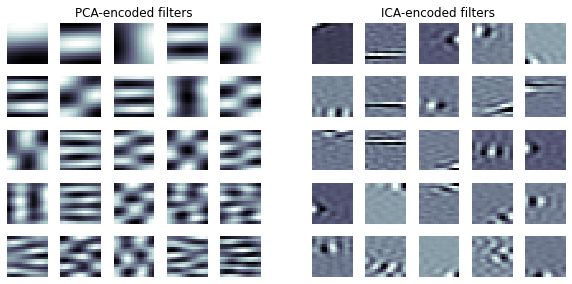

In [ ]:
fig = plt.figure(figsize=(10, 10))
plot1 = fig.add_subplot(121)
plot1.title.set_text('PCA-encoded filters')
# display encoded PCA-resultant filters
pca_comp = pcafit.components_
ica_helper_methods.showPatchesBW(np.transpose(pca_comp), 25)

plot2 = fig.add_subplot(122)
plot2.title.set_text('ICA-encoded filters')
# display encoded ICA-resultant filters
ica_comp = icafit.components_
ica_helper_methods.showPatchesBW(np.transpose(ica_comp), 25)

plt.show()

Notice that in some of these resulting filter patches, the results look familiar. That is because they resemble live recorded V1 simple cell receptive fields! For example, below is a modeled receptive field produced through this code in contrast to a recorded one. These are both sensitive to the same orientation and spatial frequency.

<img src="figures/modelvslive.png" width="100%" height="100%">
***



# Applying ICA/PCA on Unnatural Black and White Images
***

What happens when you apply the same code to "non-natural" images? The difference between natural and unnatural images has to do with what our brains have evolved to process over time, as well as shared statistical properties. For our purposes, natural images would consist of scenery such as forests and prairies, while unnatural images would consist of white noise patterns. These would not produce neural-like filters. Note that the steps performed for efficient coding of unnatual images are similar to that for natural images, except that natural images will be replaced by non-natural ones.

## 1. Extract random samples (patches) from sensory data

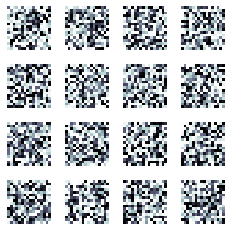

In [ ]:
# collect black and white patches from unnatural images and display them
patchesBWUnnatural = ica_helper_methods.collectPatchesBW(50000, 16, '/content/drive/MyDrive/NEC/BW/unnatural/')
ica_helper_methods.showPatchesBW(patchesBWUnnatural)

## 2. Run encoding algorithms on the extracted patches

In [ ]:
# apply PCA algorithm on the extracted patches
pcatemp = sklearn.decomposition.PCA(n_components=50)
pcafit = pcatemp.fit(np.transpose(patchesBWUnnatural))

# apply ICA algorithm on the extracted patches
icatemp = sklearn.decomposition.FastICA(n_components=75)
icafit = icatemp.fit(np.transpose(patchesBWUnnatural))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


## 3. Display neurally-encoded patches (filters)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plot1 = fig.add_subplot(121)
plot1.title.set_text('PCA-encoded filters')
# display the encoded filters resulting from PCA algorithm
pca_comp = pcafit.components_
ica_helper_methods.showPatchesBW(np.transpose(pca_comp), 25)

plot2 = fig.add_subplot(122)
plot2.title.set_text('ICA-encoded filters')
# display the encoded filters resulting from ICA algorithm
ica_comp = icafit.components_
ica_helper_methods.showPatchesBW(np.transpose(ica_comp), 25)

plt.show()

***

***
<a id="color"></a>
<h1 style="text-align:center;">Efficient Coding Implementation: Color Vision</h1>
***

This section demonstrates encoding of color images by applying two encoding algorithms: (1) **Independent Components Analysis (ICA)** and (2) **Principal Components Analysis (PCA)**. Note that the neural coding strategy of ICA is demonstrated in comparison to that of PCA. Both of these algorithms are applied on **natural and non-natural images** to analyze the resulting filters.

We typically do not see the world in greyscale, so how is color represented and processed efficiently? Despite slightly different input given that we are now accounting for a third domain of info, RGB, our method of modeling efficient coding does not vary. We are still collecting data, extracting patches, applying the appropriate encoding strategy, and displaying the resulting neural filters.

<a name="color"></a>
# Applying ICA/PCA to Natural Color Images
***

## 1. Extract random samples (patches) from sensory data

Recall the steps outlined for efficient coding. The first step in performing efficient coding is to extract random samples (or, **patches**) from the collected sensory data. This is achieved using ***collectPatchesColor( )***. Further, we display the extracted patches using the ***showPatchesColor( )*** method.

In [ ]:
# collect color patches from natural images and display them
patchesColorNatural = ica_helper_methods.collectPatchesColor(500000, 16, 'color/natural/')
ica_helper_methods.showPatchesColor(patchesColorNatural)

## 2. Run encoding algorithms on extracted patches

Once patches are extracted from the sensory data, the next step is to apply an encoding algorithm to derive the proper neural coding strategy.

In [ ]:
# find PCA components by applying PCA algorithm on the extracted patches
pcatemp = sklearn.decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(np.transpose(patchesColorNatural))

# find ICA components by applying ICA algorithm on the extracted patches
icatemp_c = sklearn.decomposition.FastICA(n_components=75)
icafit_c = icatemp_c.fit(np.transpose(patchesColorNatural))

## 3. Display neurally-encoded patches (filters)

Finally, we display the resulting filters that represent receptive fields to show what they look like once the efficient coding algorithms are run.

In [ ]:
fig = plt.figure(figsize=(10, 10))
plot1 = fig.add_subplot(121)
plot1.title.set_text('PCA-encoded filters')
# display the encoded filters resulting from PCA algorithm
pca_comp = pcafit.components_
ica_helper_methods.showPatchesColor(np.transpose(pca_comp), 25)

plot2 = fig.add_subplot(122)
plot2.title.set_text('ICA-encoded filters')
# display the encoded filters resulting from ICA algorithm
ica_comp_c = icafit_c.components_
ica_helper_methods.showPatchesColor(np.transpose(ica_comp_c), 25)

plt.show()

***

# Applying ICA/PCA to Unnatural Color Images

Here, we once again see gabor filters as a result of using ICA that mirror recorded simple cell receptive fields. The main difference that we see between here and black and white images is some green and blue, which reflects Opponent-Process Theory. We see predominantly greyscale as the brain prioritizes luminance of visual stimuli.

In comparison to "non-natural" color images, which for our purposes includes psychedelic images never seen in natural settings, the produced filter do not look neural.

## 1. Extract random samples (patches) from sensory data

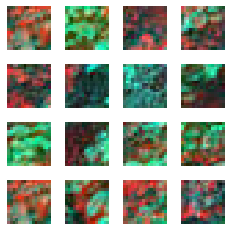

In [ ]:
# collect color patches from non-natural images and display them
patchesColorUnnatural = ica_helper_methods.collectPatchesColor(500000, 16, '/content/drive/MyDrive/NEC/color/unnatural/')
ica_helper_methods.showPatchesColor(patchesColorUnnatural)

## 2. Run encoding algorithms on extracted patches

In [ ]:
# find PCA components by applying PCA algorithm on the extracted patches
pcatemp = sklearn.decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(np.transpose(patchesColorUnnatural))

# find ICA components by applying ICA algorithm on the extracted patches
icatemp_c = sklearn.decomposition.FastICA(n_components=75)
icafit_c = icatemp_c.fit(np.transpose(patchesColorUnnatural))

## 3. Display neurally-encoded patches (filters)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plot1 = fig.add_subplot(121)
plot1.title.set_text('PCA-encoded filters')
# display the encoded filters resulting from PCA algorithm
pca_comp = pcafit.components_
ica_helper_methods.showPatchesColor(np.transpose(pca_comp), 25)

plot2 = fig.add_subplot(122)
plot2.title.set_text('ICA-encoded filters')
# display the encoded filters resulting from ICA algorithm
ica_comp_c = icafit_c.components_
ica_helper_methods.showPatchesColor(np.transpose(ica_comp_c), 25)

plt.show()

***

***
<a id="audio"></a>
<h1 style="text-align:center;">Efficient Coding Implementation: Audio Signals</h1>
***

This notebook demonstrates the application of efficient coding hypothesis to a completely different sensory modality, hearing. We attempt to model low-level processing that occurs in the auditory nerve using Independent Components Analysis (ICA) and Principal Components Analysis (PCA). Recordered filters that occur in the auditory nerve look like this and are known as <b>gammatone filters</b>.

<img src="figures/gamma.png" width="50%" height="50%">

As with other modalities, the steps followed for efficient coding remains the same, except for the type of input. Since we are modeling the processing of auditory nerve signals, we utilize audio clips as input. That is,
1. Collect an audio clip and extract random patches.
2. Apply the encoding algorithm to derive filters.
3. Display the resulting filters.

We run the encoding algorithms on natural and non-natural sound clips to analyze and understand the resulting filters.


<a name="audio"></a>
# Applying ICA/PCA to Natural Audio Signals
***

## 1. Extract random samples (patches) from sensory data

As outlined previously, the first step in performing efficient coding is to extract random samples (or, **patches**) from the collected sensory data. This is achieved using ***collectPatchesAudio( )***. Further, we display the extracted patches using the ***showPatchesAudio( )*** method.

In [ ]:
# collect audio patches from natural audio clips and display them
naturalSound = ica_helper_methods.collectPatchesAudio('bill')
ica_helper_methods.showPatchesAudio(naturalSound)

## 2. Run encoding algorithms on extracted patches

Once patches are extracted from the sensory data, the next step is to apply an encoding algorithm to derive the proper neural coding strategy.

In [ ]:
# find PCA components by applying PCA algorithm on the extracted patches
pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(naturalSound)

# find ICA components by applying ICA algorithm on the extracted patches
icatemp = sklearn.decomposition.FastICA(n_components=25)
icafit = icatemp.fit(naturalSound)

## 3. Display neurally-encoded patches (filters)

Finally, we display the resulting filters that represent receptive fields to show what they look like once the efficient coding algorithms are run.

In [ ]:
# display the encoded filters resulting from PCA algorithm
pca_comp = pcafit.components_
ica_helper_methods.showPatchesAudio(pca_comp)
print("\n\n")
# display the encoded filters resulting from ICA algorithm
ica_comp = icafit.components_
ica_helper_methods.showPatchesAudio(ica_comp)

Here, our "natural" sound clip example comes from a speech. When we run PCA and ICA, we can see that some of the resulting audio patches resemble the gammatone filter as shown previously. Resulting PCA filters do not reflect neural responses.

<img src="figures/gamma2.png" width="100%" height="100%">
***

# Applying ICA/PCA on Unnatural Audio Signals
***

Note that in unnatural soundclips, such as for pure whitenoise, gammatone filters are no longer extracted.

## 1. Extract random samples (patches) from sensory data

In [ ]:
# collect audio patches from non-natural audio clips and display them
unnaturalSound = ica_helper_methods.collectPatchesAudio('whitenoise')
ica_helper_methods.showPatchesAudio(unnaturalSound)

## 2. Run encoding algorithms on extracted patches

In [ ]:
# find PCA components by applying PCA algorithm on the extracted patches
pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(unnaturalSound)

# find ICA components by applying ICA algorithm on the extracted patches
icatemp = sklearn.decomposition.FastICA(n_components=25)
icafit = icatemp.fit(unnaturalSound)

## 3. Display neurally-encoded patches (filters)

In [ ]:
# display the encoded filters resulting from PCA algorithm
pca_comp = pcafit.components_
ica_helper_methods.showPatchesAudio(pca_comp)
print("\n\n")
# display the encoded filters resulting from ICA algorithm
ica_comp = icafit.components_
ica_helper_methods.showPatchesAudio(ica_comp)

<a name="binocular"></a>
***
# Applying ICA/PCA to Natural Binocular Images
This section demonstrates encoding of binocular vision, represented in stereograms and applies Independent Component Analysis (ICA)

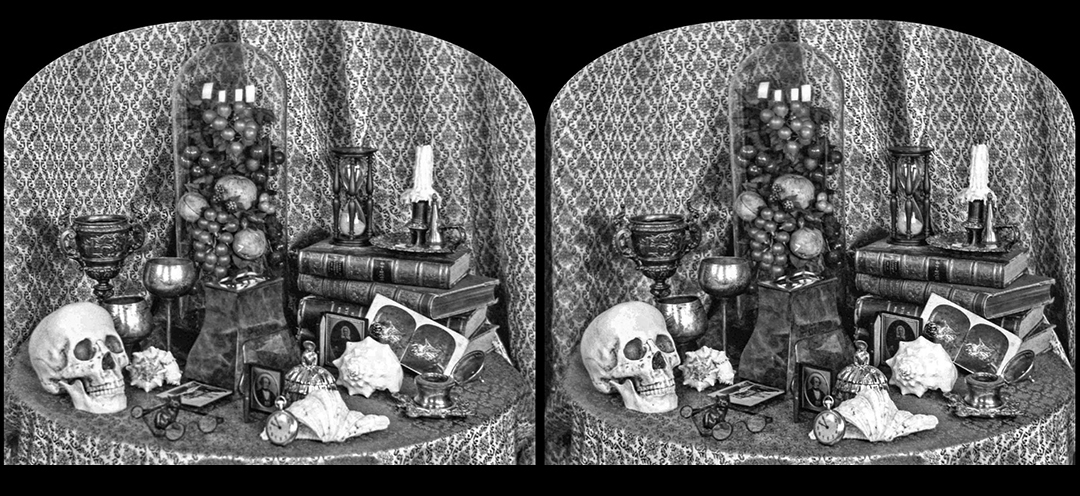

## 1. Extract random samples (patches) from a stereoscopic image

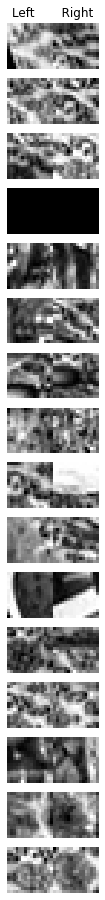

In [ ]:
patchesBinocular = ica_helper_methods.collectPatchesBinocular(50000, 16, '/content/drive/MyDrive/neural_efficient_coding/code_data_snapshot_10142019/binocular/')

left = patchesBinocular[0]
right = patchesBinocular[1]

ica_helper_methods.showPatchesBinocular(left, right, 16)

## 2. Run encoding algorithms on the extracted patches

**This code section will take about 3 minutes to run**

In [ ]:
# find ICA components by applying ICA algorithm on the extracted patches
print("Starting...")
icatemp = sklearn.decomposition.FastICA(n_components=128)
icafit = icatemp.fit(np.transpose(left))
print("Half way done!")
icatemp1 = sklearn.decomposition.FastICA(n_components=128)
icafit1 = icatemp1.fit(np.transpose(right))

Starting...
Half way done!


## 3. Display neurally-encoded patches (filters)

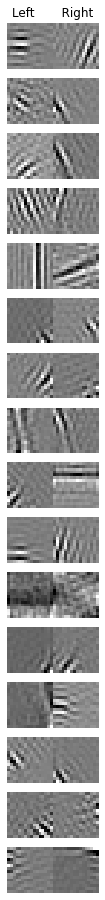

In [ ]:
ica_compL = icafit.components_
ica_compR = icafit1.components_

ica_helper_methods.showFiltersBinocular(np.transpose(ica_compL),np.transpose(ica_compR), 16)

The last step is to display the ICA derived filters that resemble the experimentally measured receptive fields.

<a name="binocular"></a>
***
# Applying ICA/PCA to Unnatural Binocular Images
This section demonstrates encoding of unnatural binocular vision, represented in a stereogram that is an impossible way to look (both eyes looking at completely different images with no overlap) and applies Independent Component Analysis (ICA)

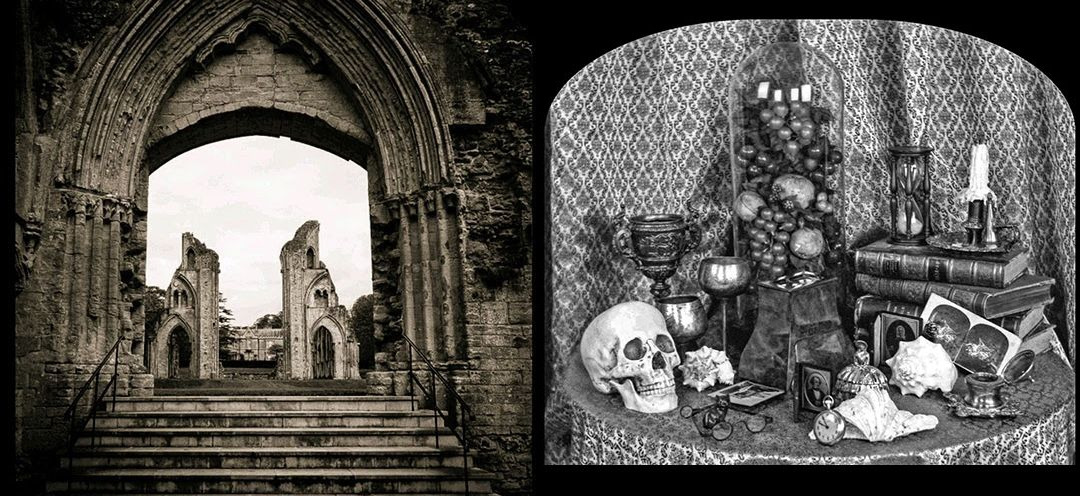

## 1. Extract random samples (patches) from a stereoscopic image

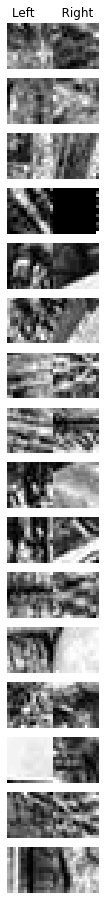

In [ ]:
patchesBinocular = ica_helper_methods.collectPatchesBinocular(50000, 16, '/content/drive/MyDrive/neural_efficient_coding/code_data_snapshot_10142019/binocular/')

left = patchesBinocular[0]
right = patchesBinocular[1]

ica_helper_methods.showPatchesBinocular(left, right, 16)

## 2. Run encoding algorithms on the extracted patches

**This code section will take about 3 minutes to run**

In [ ]:
# find ICA components by applying ICA algorithm on the extracted patches
#run this to install it: pip3 install progress progressbar2 alive-progress tqdm


print("Starting...")
icatemp = sklearn.decomposition.FastICA(n_components=128)
icafit = icatemp.fit(np.transpose(left))
print("Half way done!")
icatemp1 = sklearn.decomposition.FastICA(n_components=128)
icafit1 = icatemp1.fit(np.transpose(right))


Starting...
Half way done!


## 3. Display neurally-encoded patches (filters)

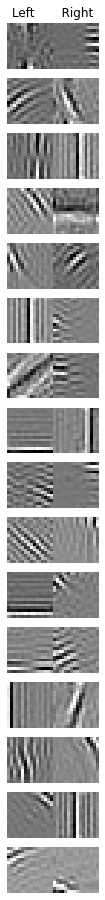

In [ ]:
ica_compL = icafit.components_
ica_compR = icafit1.components_

ica_helper_methods.showFiltersBinocular(np.transpose(ica_compL),np.transpose(ica_compR), 16)

<a name="video"></a>
***
# Applying ICA/PCA to Natural Black and White Videos
This section demonstrates encoding of black and white videos by applying two encoding algorithms: (1) Independent Components Analysis (ICA) and (2) Principal Components Analysis (PCA).

## 1. Extract random samples (patches) from sensory data


###Import modules and libraries
The ***video_patch_testing.py*** helper functions file is also imported. For more details on the video patch helper function, refer to video_patch_testing.py

In [ ]:
import video_patch_testing as vp

The first step in applying neural efficient coding is to collect random patches (***collectPatchesVideoBW***) from the video dataset and display them (***showSliceBW***). The detailed explanation of these functions can be found in the ***video_patch_testing.py*** file.

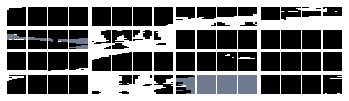

In [ ]:
# collect video patches from natural black and white videos and display them
naturalVideo = vp.collectPatchesVideoBW(50000, 32, 4, 'BW Video')
vp.showSlicesBW(naturalVideo)

## 2. Run encoding algorithms on the extracted patches

The next step is to apply Independent Component Analysis (ICA) to demonstrate neural activity in the brain comutationally. Principal Component Analysis (PCA) is also applied on the derived patches to compare with the results of ICA.

In [ ]:
# find PCA components by applying PCA algorithm on the extracted patches
#pcatemp = sklearn.decomposition.PCA(n_components=64)
#pcafit = pcatemp.fit(np.transpose(naturalVideo))

# find ICA components by applying ICA algorithm on the extracted patches
icatemp = sklearn.decomposition.FastICA(n_components=64)
icafit = icatemp.fit(np.transpose(naturalVideo))

## 3. Display neurally-encoded patches (filters)

The last step is to display the ICA derived filters that resemble the experimentally measured receptive fields.

In [ ]:
# display the encoded filters resulting from ICA algorithm
ica_comp = icafit.components_
vp.showSlicesBW(ica_comp)

***
# Applying ICA/PCA to Unnatural Black and White Videos

In [ ]:
!unzip Archive.zip

Archive:  Archive.zip
   creating: 1/
  inflating: 1/169.tiff              
   creating: __MACOSX/
   creating: __MACOSX/1/
  inflating: __MACOSX/1/._169.tiff   
  inflating: 1/186.tiff              
  inflating: __MACOSX/1/._186.tiff   
  inflating: 1/094.tiff              
  inflating: __MACOSX/1/._094.tiff   
  inflating: 1/082.tiff              
  inflating: __MACOSX/1/._082.tiff   
  inflating: 1/128.tiff              
  inflating: __MACOSX/1/._128.tiff   
  inflating: 1/190.tiff              
  inflating: __MACOSX/1/._190.tiff   
  inflating: 1/041.tiff              
  inflating: __MACOSX/1/._041.tiff   
  inflating: 1/104.tiff              
  inflating: __MACOSX/1/._104.tiff   
  inflating: 1/016.tiff              
  inflating: __MACOSX/1/._016.tiff   
  inflating: 1/153.tiff              
  inflating: __MACOSX/1/._153.tiff   
  inflating: 1/145.tiff              
  inflating: __MACOSX/1/._145.tiff   
  inflating: 1/057.tiff              
  inflating: __MACOSX/1/._057.tiff   
  

## 1. Extract Patches

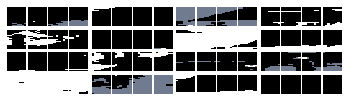

In [ ]:
# collect video patches from natural black and white videos and display them
unnaturalVideo = vp.collectPatchesVideoBW(5000, 32, 4, 'unnatural')
vp.showSlicesBW(unnaturalVideo)

## 2. Run encoding algorithms on the extracted patches

In [ ]:
# find PCA components by applying PCA algorithm on the extracted patches
pcatemp = sklearn.decomposition.PCA(n_components=100)
pcafit = pcatemp.fit(np.transpose(unnaturalVideo))

# find ICA components by applying ICA algorithm on the extracted patches
icatemp = sklearn.decomposition.FastICA(n_components=100)
icafit = icatemp.fit(np.transpose(unnaturalVideo))

## 3. Display neurally-encoded patches (filters)

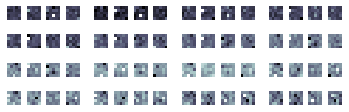

In [ ]:
# display the encoded filters resulting from PCA algorithm
pca_comp = pcafit.components_
vp.showSlicesBW(pca_comp)
print("\n\n")
# display the encoded filters resulting from ICA algorithm
ica_comp = icafit.components_
vp.showSlicesBW(ica_comp)

# Conclusions
***

This project is intended as an introduction to this concept via utilizing a tutorial-style Jupyter notebook programmed in Python to students with and without any prior programming experience.
